In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
#import torchvision.transform as transform
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "../input_data/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [2]:
diseases = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Raspberry___healthy']
print("Total disease classes are: {}".format(len(diseases)))
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
print(plants)


Total disease classes are: 6
['Apple', 'Blueberry', 'Raspberry']


In [3]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(disease)
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,18
Apple___Black_rot,17
Apple___Cedar_apple_rust,24
Apple___healthy,15
Blueberry___healthy,19
Raspberry___healthy,19


Text(0.5, 1.0, 'Images per each class of plant disease')

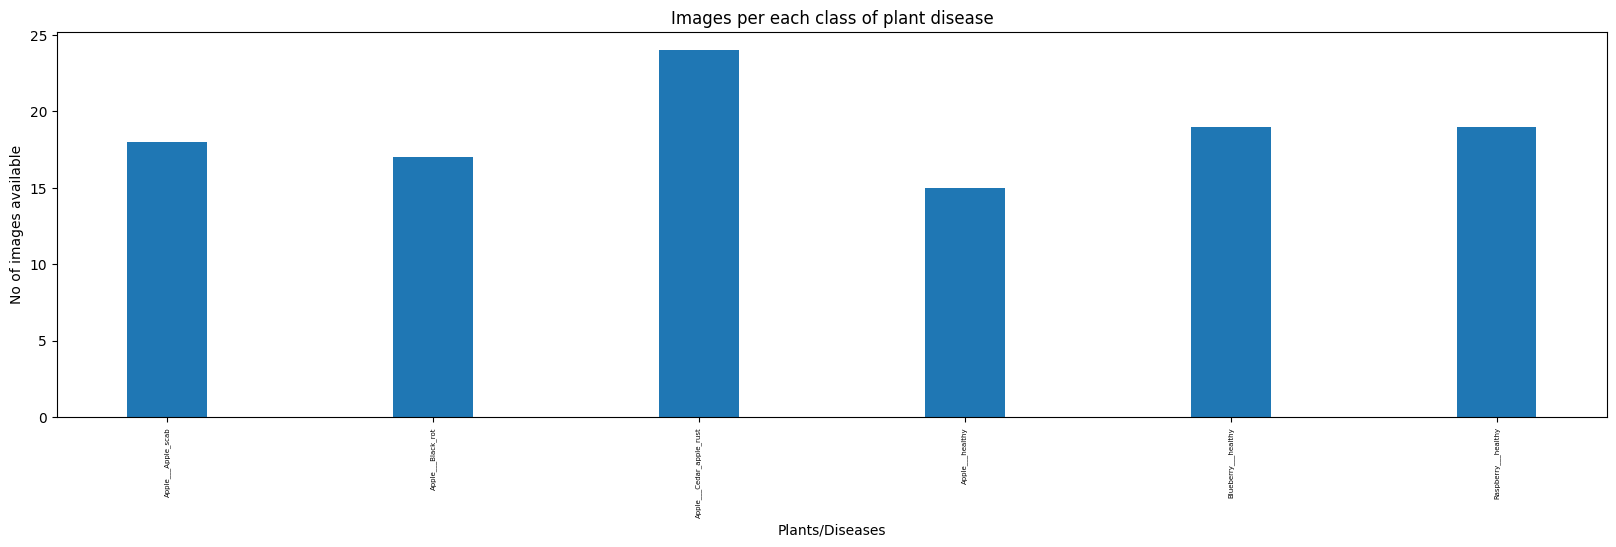

In [4]:
# plotting number of images available for each disease
index = [n for n in range(len(diseases))]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [5]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 112 images for training


In [6]:
import torchvision
# datasets for validation and training
data_dir = os.chdir('/content/drive/MyDrive/input_data/NewPlantDiseasesDataset(Augmented)/NewPlantDiseasesDataset(Augmented)')
!ls
!pwd
train = ImageFolder('/content/drive/MyDrive/input_data/NewPlantDiseasesDataset(Augmented)/NewPlantDiseasesDataset(Augmented)/train', transform=torchvision.transforms.ToTensor())
#os.chdir('/content/drive/MyDrive/input_data/NewPlantDiseasesDataset(Augmented)/NewPlantDiseasesDataset(Augmented)')
valid = ImageFolder('/content/drive/MyDrive/input_data/NewPlantDiseasesDataset(Augmented)/NewPlantDiseasesDataset(Augmented)/valid', transform=torchvision.transforms.ToTensor()) 

train  valid
/content/drive/MyDrive/input_data/NewPlantDiseasesDataset(Augmented)/NewPlantDiseasesDataset(Augmented)


In [7]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [8]:
len(train.classes)

6

In [9]:
def show_image(image,label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


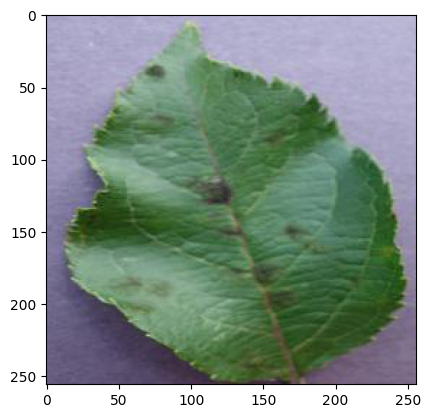

In [10]:
show_image(*train[0])

In [11]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)
batch_size = 32

In [12]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [13]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("gpu")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            #print(b)
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        print('batches"',len(self.dl))
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [17]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [18]:
class ResNet(ImageClassificationBase):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x 

In [19]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

In [20]:
model=resnet34()

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model.state_dict(), PATH)

In [21]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [23]:
import torch.nn.functional as F # for functions for calculating loss

model = model.to("cuda")
#valid_dl = valid_dl.to("cuda")

In [24]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 10.6 s, sys: 1.27 s, total: 11.9 s
Wall time: 14min 56s


[{'val_loss': tensor(6.9195, device='cuda:0'), 'val_accuracy': tensor(0.)}]

In [25]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.0911, val_loss: 1.8466, val_acc: 0.5260
Epoch [1], last_lr: 0.00000, train_loss: 0.3891, val_loss: 0.1529, val_acc: 0.9463
CPU times: user 56.4 s, sys: 31.2 s, total: 1min 27s
Wall time: 1h 7min 13s


In [27]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

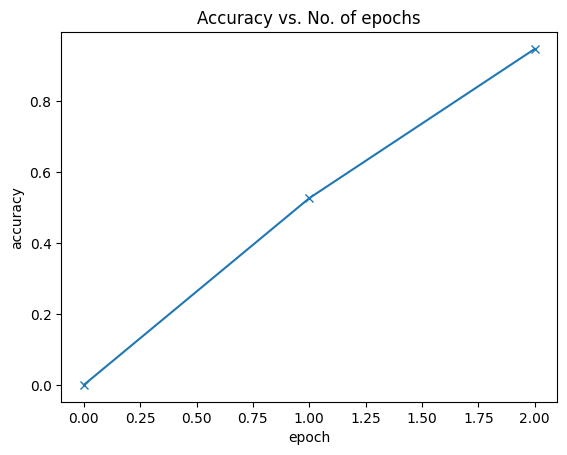

In [28]:
plot_accuracies(history)

TypeError: ignored

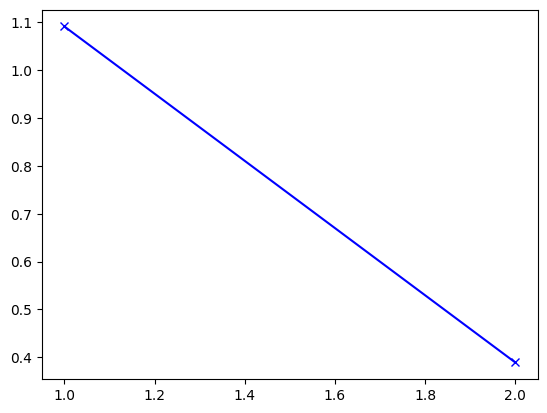

In [30]:
plot_losses(history)

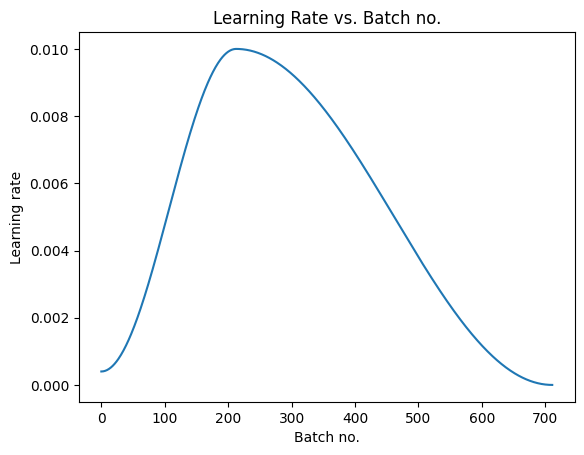

In [31]:
plot_lrs(history)